# I. Preparation

In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from nn_interpretability.model.model_trainer import ModelTrainer
from nn_interpretability.model.model_repository import ModelRepository
from nn_interpretability.interpretation.cam.grad_cam import GradCAMInterpreter
from nn_interpretability.visualization.mnist_visualizer import MnistVisualizer
from nn_interpretability.dataset.mnist_data_loader import MnistDataLoader

In [2]:
model_name = 'cam_classifier.pt'

extended_model_name = 'cam_extended_classifier.pt'

train = False

In [3]:
mnist_data_loader = MnistDataLoader()

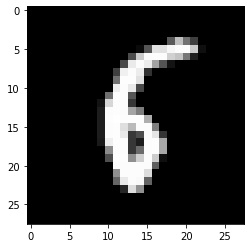

In [4]:
MnistVisualizer.show_dataset_examples(mnist_data_loader.trainloader)

# II. Grad-CAM

Gradient-Weighted Class Activation Maps (Grad-CAM) is a generalization of the CAM method, which uses the gradient signal instead of the weights of the last layer for weighing the activations. This makes the method reusable for any kind of CNN models unlike the original CAM method. Furthermore, Grad-CAM can be applied to practically any CONV layer of the CNN model which produces a meaningful gradient signal. 

<p float="center">
  <img src="./assets/grad_cam_formula.png"/>
</p>

Grad-CAM is being computed by multiplying the activations from the forward pass of the chosen layers with global-averaged-pooled incoming gradient from the backward pass. The result of the multiplication is then run through a ReLU activation. The final result is upsampled to the dimensions of the original input.

In [5]:
def generate_cams(interpreter):
    images = []
    cams = []

    for i in range(10):
        img = mnist_data_loader.get_image_for_class(i)
        cam = interpreter.interpret(img)

        images.append(img.cpu().numpy().reshape(28, 28))
        cams.append(cam.numpy().reshape(28, 28))
    
    return images, cams

In [6]:
def display_cams(images, cams, show_images = True):
    for i in range(5):
        plt.figure(figsize=(10,10))
        for j in range(2):
            plt.subplot(5, 2, i * 2 + j + 1)
            if show_images:
                plt.imshow(images[i*2 + j], cmap='gray')
            plt.imshow(cams[i*2 + j], alpha=.5)
            plt.title('Digit {} GRAD-CAM'.format(i * 2 + j))
            plt.colorbar()
            plt.xticks([])
            plt.yticks([])
        plt.tight_layout()

In [7]:
def cams(model, layer_name):
    classes = [str(i) for i in range(10)]

    interpreter = GradCAMInterpreter(model, classes, None, (28, 28), layer_name)

    images, cams = generate_cams(interpreter)
    display_cams(images, cams)

## 1. Grad-CAM with model with small last activation maps (3x3)

In our first experiment, we execute Grad-CAM for a model which has small activation maps being produced by the last CONV layer. Furthermore, we exhibit the resultant Grad-CAM for each of the three available CONV layers. It is noteworthy that the quality of results becomes worse as the depth of the CONV layer under test increases.

In [8]:
model = ModelRepository.get_cam_classifier(model_name)

if train:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    model.train()
    ModelTrainer.train(model, criterion, optimizer, trainloader)
    
    ModelRepository.save(model, model_name)

### 1.1 Grad-CAM for first layer

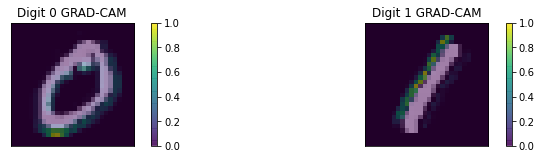

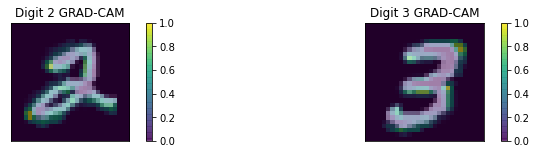

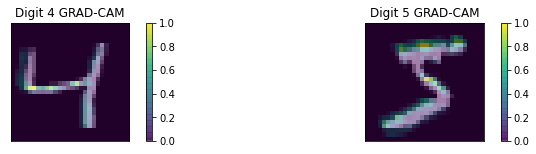

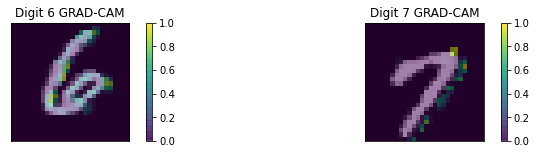

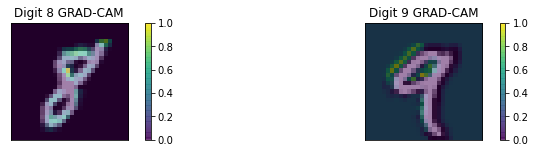

In [9]:
cams(model, 'relu1')

### 1.2 Grad-CAM for second layer

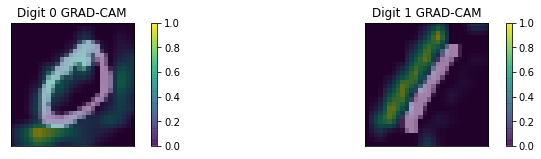

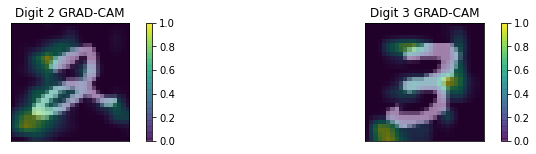

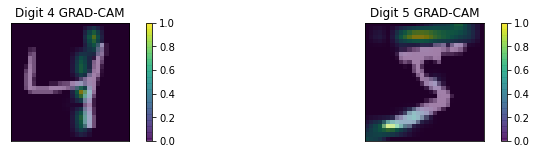

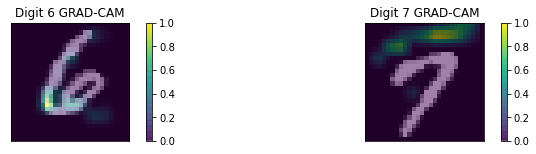

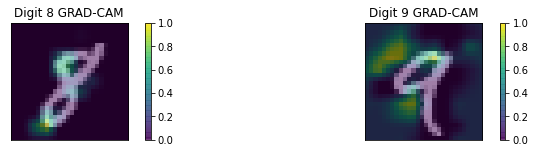

In [10]:
cams(model, 'conv2')

### 1.3 Grad-CAM for third layer

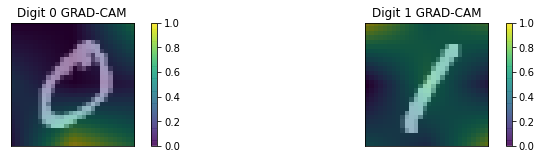

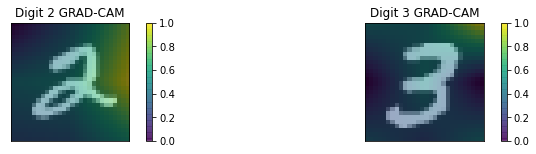

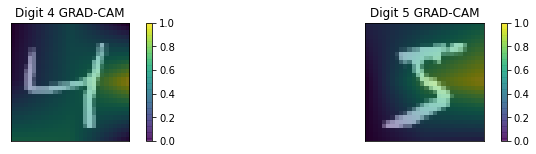

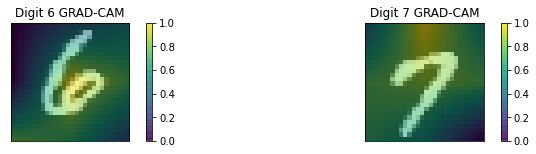

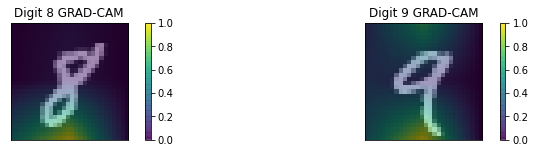

In [11]:
cams(model, 'relu3')

## 2. Grad-CAM with model with medium-sized last activation maps (6x6)

In our first experiment, we execute Grad-CAM for a model which has medium-sized activation maps being produced by the last CONV layer. Furthermore, we exhibit the resultant Grad-CAM for each of the three available CONV layers. It is noteworthy that the quality of results becomes worse as the depth of the CONV layer under test increases. However, the results here are better in comparison to the previous model mostly due to the increased size of activation maps.

In [12]:
model = ModelRepository.get_cam_extended_classifier(extended_model_name)

if train:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    model.train()
    ModelTrainer.train(model, criterion, optimizer, trainloader)
    
    ModelRepository.save(model, model_name)

### 2.1 Grad-CAM for first layer

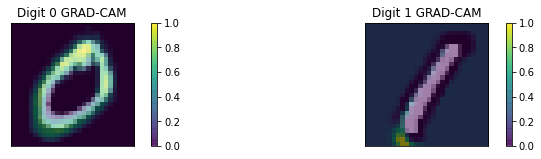

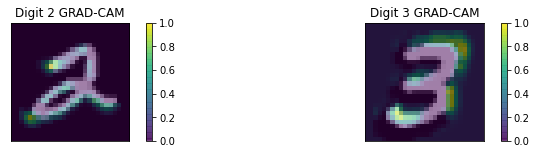

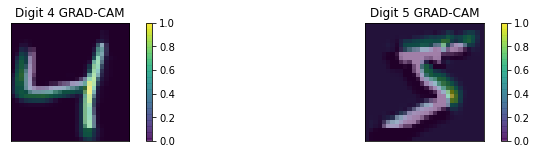

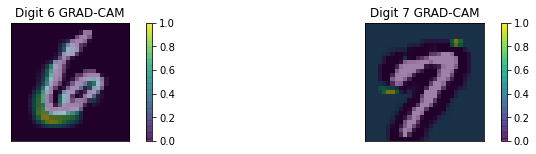

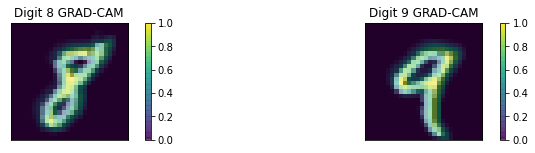

In [13]:
cams(model, 'conv1')

### 2.2 Grad-CAM for second layer

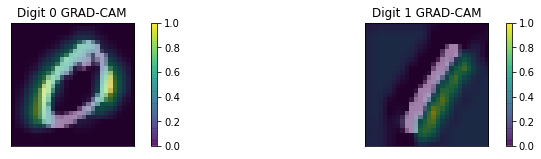

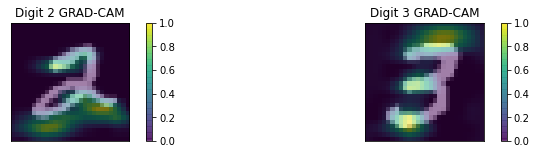

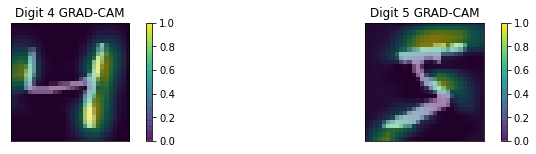

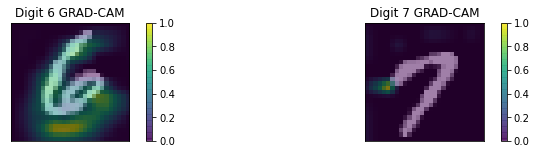

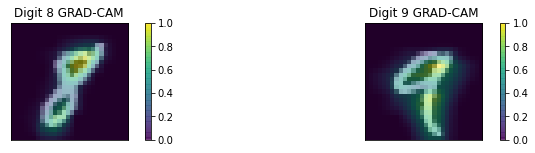

In [14]:
cams(model, 'relu2')

### 2.3 Grad-CAM for third layer

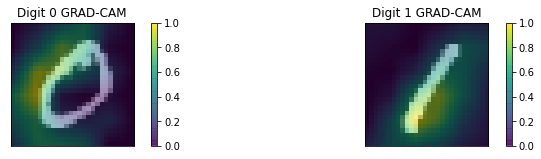

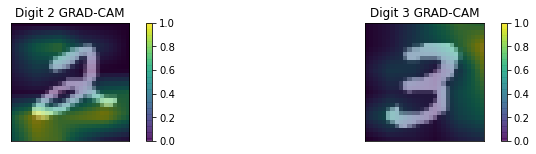

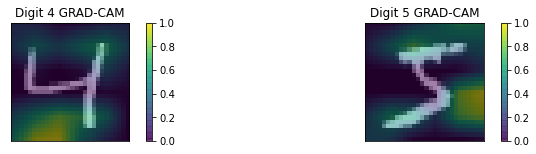

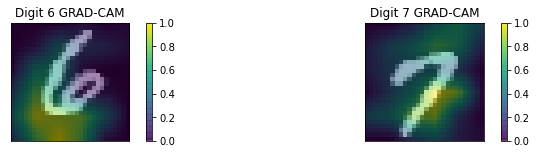

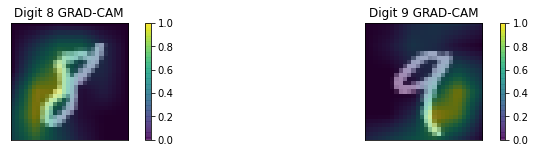

In [15]:
cams(model, 'relu3')